

# K-Nearest Neighbours 
K-NN classifier applied to classifification on the Iris dataset.

In [2]:
import numpy as np
%matplotlib inline                                  
import matplotlib.pyplot as plt
from sklearn import datasets


In [4]:
dataset = datasets.load_iris()

We create the input matrix $X \in \mathbb{R}^{N \times D}$ and the output vector $y \in \{1,\ldots,C\}^N$.
Let's only use `sepal length` and `sepal width` for classification, since we know they have high correlation with the class label and we can simplify visualization. 

instances (N) 	 150 
 features (D) 	 2 
 classes (C) 	 3


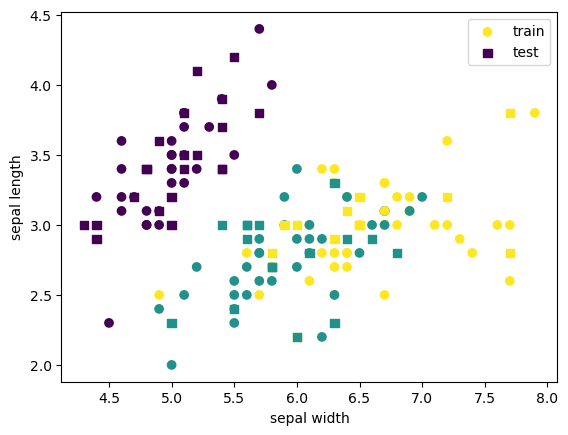

In [5]:
x, y = dataset['data'][:,:2], dataset['target']              

(N,D), C = x.shape, np.max(y)+1
print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')

inds = np.random.permutation(N)                                                   

x_train, y_train = x[inds[:100]], y[inds[:100]]
x_test, y_test = x[inds[100:]], y[inds[100:]]

plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', label='train')
plt.scatter(x_test[:,0], x_test[:,1], c=y_test, marker='s', label='test')
plt.legend()
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.show()

### The `KNN` class

In [6]:
#distanace functions
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)

class KNN:

    def __init__(self, K=1, dist_fn= euclidean):
        self.dist_fn = dist_fn
        self.K = K
        self.x = None
        self.y = None
        self.C = None
        self.trained = False
        return
    
    def fit(self, x, y):
        ''' Store the training data using this method as it is a lazy learner'''
        self.x = x
        self.y = y
        self.C = np.max(y) + 1
        self.trained = True
        return self
    
    def predict(self, x_test):
        ''' Makes a prediction using the stored training data and the test data given as argument'''
        num_test = x_test.shape[0]
        #calculate distance between the training & test samples and returns an array of shape [num_test, num_train]
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])
        #ith-row of knns stores the indices of k closest training samples to the ith-test sample 
        knns = np.zeros((num_test, self.K), dtype=int)
        y_prob = np.zeros((num_test, self.C))
        for i in range(num_test):
            knns[i,:] = np.argsort(distances[i])[:self.K]
             #counts the number of instances of each class in the K-closest training samples
            y_prob[i,:] = np.bincount(self.y[knns[i,:]], minlength=self.C)
        #simply divide by K to get a probability distribution
        y_prob /= self.K
        return y_prob, knns

accuracy is 84.0.


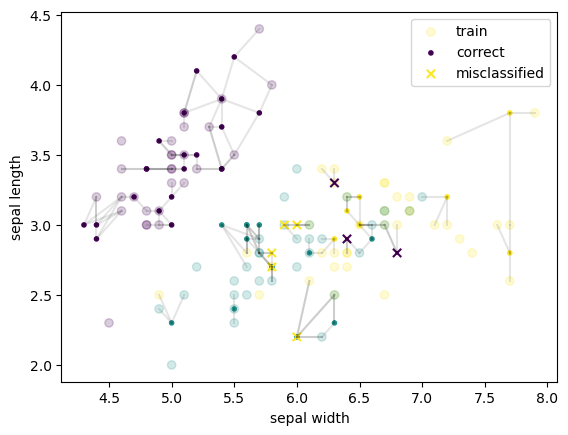

In [8]:
model = KNN(K=3)

y_prob, knns = model.fit(x_train, y_train).predict(x_test)

y_pred = np.argmax(y_prob,axis=-1)
accuracy = np.sum(y_pred == y_test)/y_test.shape[0]

print(f'accuracy is {accuracy*100:.1f}.')

correct = y_test == y_pred
incorrect = np.logical_not(correct)

#visualization of the points
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', alpha=.2, label='train')
plt.scatter(x_test[correct,0], x_test[correct,1], marker='.', c=y_pred[correct], label='correct')
plt.scatter(x_test[incorrect,0], x_test[incorrect,1], marker='x', c=y_test[incorrect], label='misclassified')

#connect each node to k-nearest neighbours in the training set
for i in range(x_test.shape[0]):
    for k in range(model.K):
        hor = x_test[i,0], x_train[knns[i,k],0]
        ver = x_test[i,1], x_train[knns[i,k],1]
        plt.plot(hor, ver, 'k-', alpha=.1)
    
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.legend()
plt.show()

### Decision Boundaries

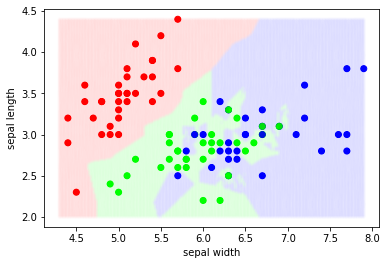

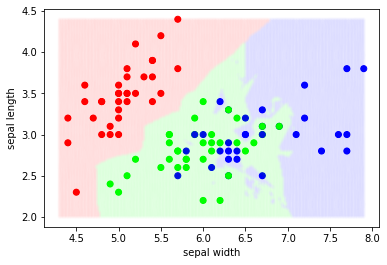

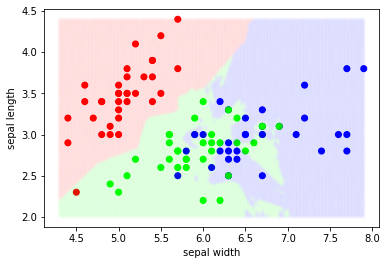

In [ ]:
#we can make the grid finer by increasing the number of samples from 200 to higher value
x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)

#to features values as a mesh  
x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

for k in range(1,4):
  model = KNN(K=k)

  y_train_prob = np.zeros((y_train.shape[0], C))
  y_train_prob[np.arange(y_train.shape[0]), y_train] = 1

  #to get class probability of all the points in the 2D grid
  y_prob_all, _ = model.fit(x_train, y_train).predict(x_all)

  y_pred_all = np.zeros_like(y_prob_all)
  y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1

  plt.scatter(x_train[:,0], x_train[:,1], c=y_train_prob, marker='o', alpha=1)
  plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_all, marker='.', alpha=0.01)
  plt.ylabel('sepal length')
  plt.xlabel('sepal width')
  plt.show()

### The Effect of Noise and Feature Scaling
Nearest neighbours are highly affected by the existence of noisy or irrelevant features.
Lets add noise and see how it affects the accuracy of our classifier.

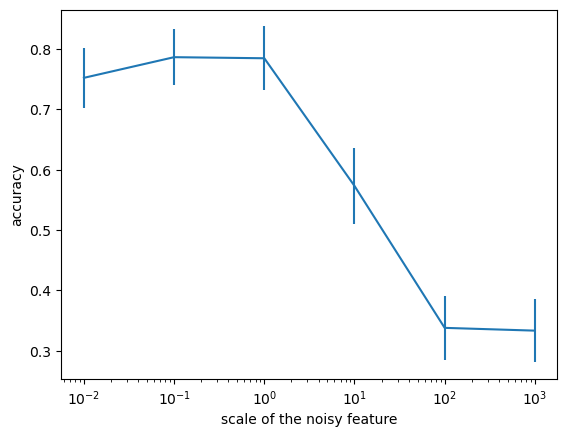

In [9]:
noise_scale = [.01, .1, 1, 10, 100, 1000]
#generate random noise
noise = np.random.randn(x.shape[0],1)
results = []
for s in noise_scale:
    #add noise as an extra feature
    x_n = np.column_stack((x, noise*s))
    results.append([])
    #repeat the experiment 100 times with different train and test split
    for r in range(100):
        #data processing and train-test split
        inds = np.random.permutation(N)
        x_train, y_train = x_n[inds[:100]], y[inds[:100]]
        x_test, y_test = x_n[inds[100:]], y[inds[100:]]
        #define model
        model = KNN(K=3)
        #prediction
        y_prob, _ = model.fit(x_train, y_train).predict(x_test)
        y_pred = np.argmax(y_prob,1)
        accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
        results[-1].append(accuracy)
results = np.array(results)
plt.errorbar(noise_scale, results.mean(1), results.std(1))
plt.xscale('log')
plt.xlabel("scale of the noisy feature")
plt.ylabel("accuracy")
plt.show()

We see that as we increase the scale of irrelevant feature it plays a more important role when calculating distances, and so the K nearest neighbors are more decided by the noisy feature rather than the relevant ones.